In the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb) post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce several concepts as needed. These include:
* hierarchical models sometimes referred to as multilevel or partially pooled models,
* varying effects,
* gaussian processes to introduce inference on potential covariance between unobserved variables (parameters).

In [71]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot
import theano.tensor as tt

In [118]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18

Load the training dataset. The rrs data was imputed where necessary from adjacent bands, either by direct assignment or via linear modeling (regression). This step can be found [here](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb).

In [59]:
df = pd.read_pickle('./pickleJar/dfNomad_AOP.pkl')

In [60]:
df.head().T

,0,1,2,3,4
id,1565,1566,1567,1568,1559
datetime,2003-04-15 15:15:00,2003-04-15 16:50:00,2003-04-15 17:50:00,2003-04-17 18:15:00,2003-07-21 18:27:00
doy,105.875,106.5,106.542,108,203.2
lat,38.4279,38.368,38.3074,38.6367,38.3047
lon,-76.61,-76.5,-76.44,-76.32,-76.44
Biome,Coastal,Coastal,Coastal,Coastal,Coastal
BiomCat,0,0,0,0,0
Province,NW Atlantic Shelves Province,NW Atlantic Shelves Province,NW Atlantic Shelves Province,NW Atlantic Shelves Province,NW Atlantic Shelves Province
ProvCode,NWCS,NWCS,NWCS,NWCS,NWCS
ProvCat,17,17,17,17,17


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 29 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
doy             4459 non-null float64
lat             4459 non-null float64
lon             4459 non-null float64
Biome           4459 non-null object
BiomCat         4459 non-null int8
Province        4459 non-null object
ProvCode        4459 non-null object
ProvCat         4459 non-null int64
etopo2          4459 non-null float64
bathymetry      4459 non-null float64
oisst           4459 non-null float64
wtemp           1235 non-null float64
woa_sst_mean    2516 non-null float64
woa_sst_se      2516 non-null float64
sal             672 non-null float64
woa_sal_mean    2511 non-null float64
woa_sal_se      2511 non-null float64
rrs411          4293 non-null float64
rrs443          4456 non-null float64
rrs489          4422 non-null float64
rrs510          4207 non-null float64
rrs555          4453 n

### Exploring categorization with heritage predictor; $log \left(\frac{max(blue)}{green}\right)$

For reference, I will recalculate features used in the modeling described in the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb). The specific data will include max(Rrs443,Rrs489, Rrs510) - 'mxBl', the blue wavelength that was used in each observation - mxBlId, its corresponding numeric code -mxBlCat, the blue-to-green ration of OC4 - mxBl2Gr, the region and biome each observation belongs to - 'province', 'biome', and their respective numeric code, 'provCat' and 'biomCat' respectively, and chlorophyll *a* - chl. The ...Cat columns will be used later as group index in the hierarchical models.

In [78]:
df_0 = pd.DataFrame(index= df.index,
                    columns=['mxBl', 'mxBlId', 'mxBlCat', 'mxBl2Gr', 'mxBl2Gr_l',
                             'province', 'provCode', 'provCat',
                             'biome', 'biomCat', 'chl', 'chl_l'])

In [79]:
df_0['mxBl'] = df[['rrs443', 'rrs489', 'rrs510']].max(axis=1)
df_0['mxBlId'] = df[['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1)
df_0['mxBlCat'] = df_0.mxBlId.astype('category').cat.codes
df_0['mxBl2Gr'] = df_0.mxBl / df.rrs555
df_0['mxBl2Gr_l'] = np.log10(df_0.mxBl2Gr)
df_0['province'] = df.Province
df_0['provCode'] = df.ProvCode
df_0['provCat'] = df.ProvCat
df_0['biome'] = df.Biome
df_0['biomCat'] = df.BiomCat
df_0['chl'] = df.chl
df_0['chl_l'] = np.log10(df.chl)

In [80]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 12 columns):
mxBl         4459 non-null float64
mxBlId       4459 non-null object
mxBlCat      4459 non-null int8
mxBl2Gr      4453 non-null float64
mxBl2Gr_l    4453 non-null float64
province     4459 non-null object
provCode     4459 non-null object
provCat      4459 non-null int64
biome        4459 non-null object
biomCat      4459 non-null int8
chl          4127 non-null float64
chl_l        4127 non-null float64
dtypes: float64(5), int64(1), int8(2), object(4)
memory usage: 357.1+ KB


Notice the *maxBlueId* column. I'll return to that in a bit. For now, plotting the band ratio and chlor_a data pairwise yields:

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


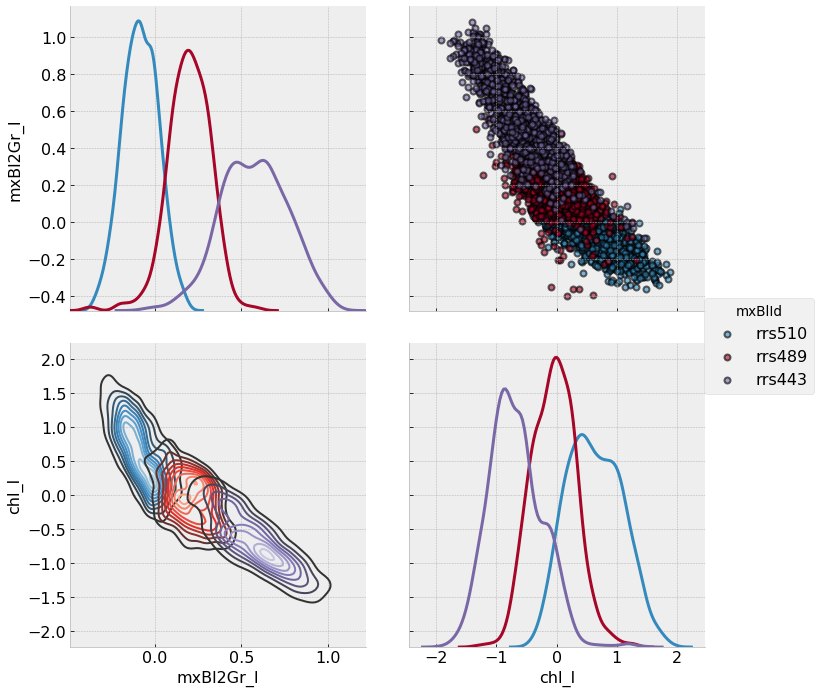

In [87]:
g = PairGrid(df_0.dropna(), vars=['mxBl2Gr_l', 'chl_l'], size=5, diag_sharey=False,
             hue='mxBlId',
             hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]});
g = g.map_upper(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
g = g.map_diag(kdeplot, lw=3)
g = g.map_lower(kdeplot);
g.add_legend();

The first thing that we can see from the imputation of the data, documented in an [earlier notebook](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb), is that the data shape no longer supports necessarily a high order polynomial as OC4. The data also shows good separability with respect to the blue band used in the ratio; both in terms of chlororphyll and band ratio distributions.<br>
Next is to look at what other possible groupings show, if anything. The groupings include Longhurst *biome* and *province* categorizations. For context, the Longhurst map looks as follows:
<img src='figJar/lhurstbiogeog.jpg'>
<br>
The biome grouping is as follows:

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


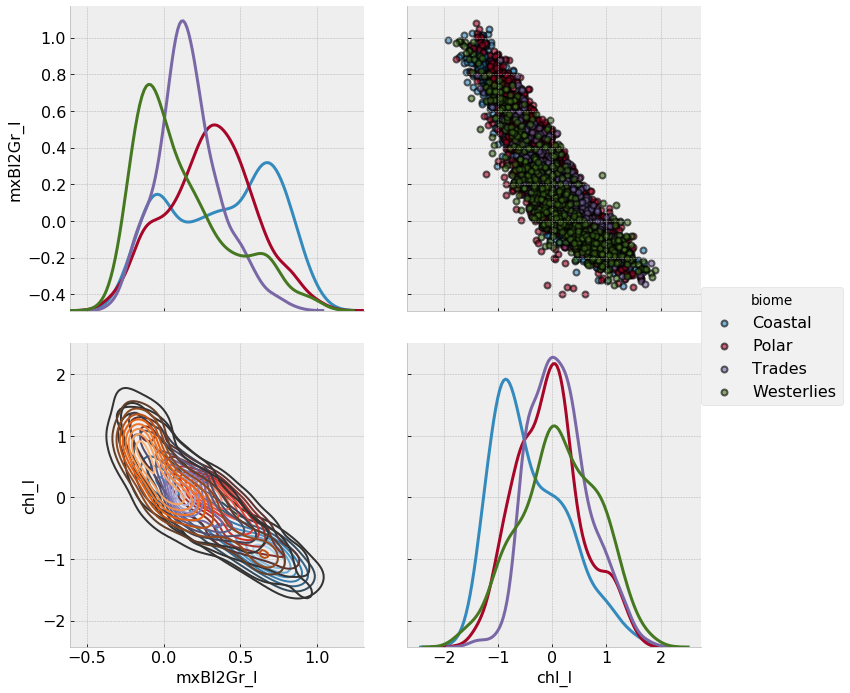

In [88]:
g = PairGrid(df_0.dropna(), vars=['mxBl2Gr_l', 'chl_l'], size=5, diag_sharey=False,
             hue='biome',
             hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d", "Oranges_d"]});
g = g.map_upper(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
g = g.map_diag(kdeplot, lw=3)
g = g.map_lower(kdeplot);
g.add_legend();

This does not show good separability, westerlies, trades and polar are pretty much overlayed in terms of chlorophyll distributions. There is somewhat clearer distinction in band ratio distributions where the peaks are concerned, but the tails, again are clearly overlapping. <br>
I'll next look at province grouping. Note in this case that I don't include the 2D KDE of the lower right graph in the pair plots above because some categories don't have enough members for a proper density estimate. The breakdown is as follows:

In [151]:
df_0.provCode.value_counts()

APLR    1175
NWCS     703
CCAL     556
NPSW     377
CARB     209
NASW     172
NATR     125
SATL     118
NPPF     114
GUIA      84
WTRA      79
NASE      68
BENG      67
ARAB      65
ARCT      58
BERS      42
MONS      38
WARM      37
KURO      37
PEQD      32
SARC      31
ETRA      27
NPTG      27
ANTA      24
BPLR      22
MEDI      16
SPSG      13
FKLD      13
ISSG      12
NEWZ      12
BRAZ      12
SANT      11
CHIL      11
CNRY      10
NECS      10
EAFR       9
ALSK       8
SUND       7
NADR       6
PNEC       5
CHIN       5
GFST       5
SSTC       4
PSAE       2
INDE       1
Name: provCode, dtype: int64

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


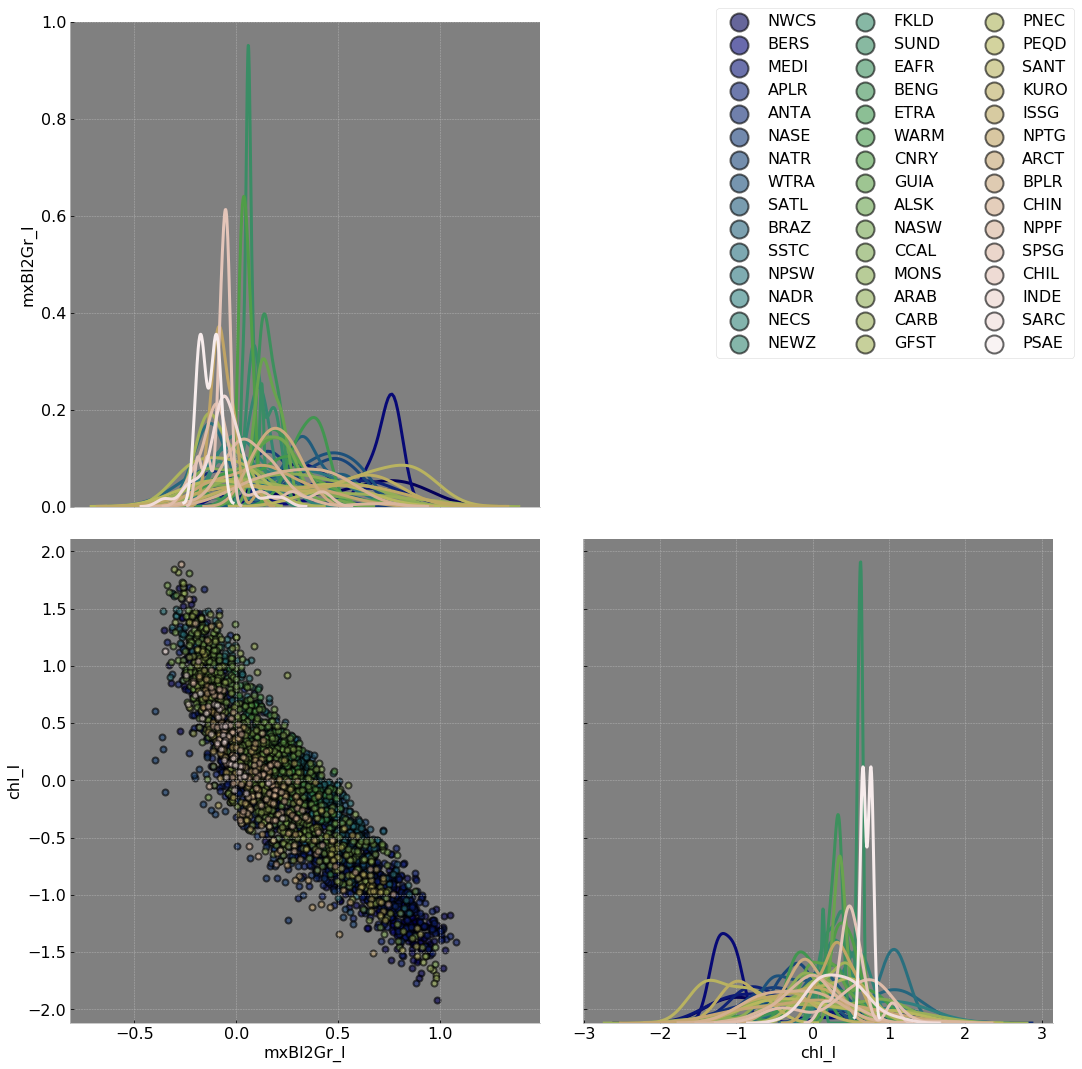

In [169]:
g = PairGrid(df_0,
             vars=['mxBl2Gr_l', 'chl_l'], size=7.5, diag_sharey=False,
             hue='provCode', palette='gist_earth'
             );
g.map_lower(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
g.map_diag(kdeplot, lw=3)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
for i, j in zip(*np.tril_indices_from(g.axes, 0)):
    g.axes[i, j].set_facecolor('gray')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3,
            markerscale=3, fontsize=16);

In [240]:
df_0.to_pickle('./pickleJar/df_legacy.pkl')

There are some provinces that are clearly distinct enough that the models developed further could potentially benefit from province-based categorization. Before proceeding with the modeling however, I will first explore some alternative models that may yield more robust results.
### Exploring alternative models

Going back unaltered data, I'll look at some relationships between potential predictors, including sst, salinity, rrs, and chl. Some of the data is log transformed.

In [184]:
df_l = pd.DataFrame(columns=['id', 'datetime', 'lat' , 'lon',
                             'etopo2_l', 'oisst_l', 'sal_l', 
                             'rrs411_l', 'rrs443_l', 'rrs489_l', 'rrs510_l', 'rrs555_l',
                             'rrs670_l', 
                             'provCode', 'provCat', 'biome', 'biomCat', 'chl_l'])

In [207]:
df_l.id = df.id
df_l.datetime = df.datetime
df_l.lat = df.lat
df_l.lon = df.lon
df_l.etopo2_l = np.log10(df.etopo2+1e-6)
df_l.oisst_l = np.log10(df.oisst+1e-6)
df_l.sal_l = np.log10(df.woa_sal_mean+1e-6)
df_l.rrs411_l = np.log10(df.rrs411)
df_l.rrs443_l = np.log10(df.rrs443)
df_l.rrs489_l = np.log10(df.rrs489)
df_l.rrs510_l = np.log10(df.rrs510)
df_l.rrs555_l = np.log10(df.rrs555)
df_l.rrs670_l = np.log10(df.rrs670)
df_l.provCode = df.ProvCode
df_l.provCat = df.ProvCat
df_l.biome = df.Biome
df_l.biomCat = df.BiomCat
df_l.chl_l = np.log10(df.chl)

In [212]:
df_l.filter(regex='rrs').dropna(how='all').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 6 columns):
rrs411_l    4293 non-null float64
rrs443_l    4456 non-null float64
rrs489_l    4422 non-null float64
rrs510_l    4207 non-null float64
rrs555_l    4453 non-null float64
rrs670_l    3822 non-null float64
dtypes: float64(6)
memory usage: 243.9 KB


In [208]:
df_l.dropna().filter(regex='rrs').describe()

,rrs411_l,rrs443_l,rrs489_l,rrs510_l,rrs555_l,rrs670_l
count,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000
mean,-2.299629,-2.329562,-2.352414,-2.473703,-2.702796,-3.819059
std,0.291353,0.262090,0.203073,0.179369,0.229652,0.427727
min,-3.744503,-3.581399,-3.533865,-3.567984,-3.683363,-5.035304
25%,-2.471891,-2.488168,-2.456000,-2.553386,-2.830556,-4.062921
50%,-2.278959,-2.301004,-2.327911,-2.476324,-2.753897,-3.873057
75%,-2.082035,-2.135066,-2.226360,-2.409379,-2.633967,-3.616469
max,-1.657386,-1.643988,-1.519995,-1.482807,-1.400121,-1.756974


In [166]:
from seaborn import pairplot

In [201]:
df_l.corr()

,lat,lon,etopo2_l,oisst_l,sal_l,rrs411_l,rrs443_l,rrs489_l,rrs510_l,rrs555_l,rrs670_l,provCat,biomCat,chl_l
lat,1.000000,-0.111997,0.003379,0.772194,0.214613,-0.163164,-0.028468,0.089760,0.143420,0.221191,0.056681,-0.027989,0.083252,-0.056352
lon,-0.111997,1.000000,0.182502,0.036882,0.262124,0.047567,0.037008,-0.011864,-0.120460,-0.180063,-0.118386,0.218099,0.077100,-0.148030
etopo2_l,0.003379,0.182502,1.000000,0.118278,0.131878,0.261781,0.235326,0.060094,-0.218376,-0.470411,-0.279368,0.092012,-0.152897,-0.479224
oisst_l,0.772194,0.036882,0.118278,1.000000,0.523497,0.071599,0.197244,0.225852,0.209470,0.144773,-0.050170,0.098361,-0.089397,-0.247885
sal_l,0.214613,0.262124,0.131878,0.523497,1.000000,0.381532,0.433828,0.387107,0.189802,-0.027454,-0.189023,0.673841,-0.197496,-0.440367
rrs411_l,-0.163164,0.047567,0.261781,0.071599,0.381532,1.000000,0.962980,0.814762,0.505131,-0.080378,-0.259450,0.347146,-0.266964,-0.650676
rrs443_l,-0.028468,0.037008,0.235326,0.197244,0.433828,0.962980,1.000000,0.920134,0.645828,0.046007,-0.204103,0.357842,-0.252832,-0.657464
rrs489_l,0.089760,-0.011864,0.060094,0.225852,0.387107,0.814762,0.920134,1.000000,0.864462,0.355675,-0.042160,0.304859,-0.159767,-0.440395
rrs510_l,0.143420,-0.120460,-0.218376,0.209470,0.189802,0.505131,0.645828,0.864462,1.000000,0.779531,0.313912,0.139341,-0.031888,-0.003366
rrs555_l,0.221191,-0.180063,-0.470411,0.144773,-0.027454,-0.080378,0.046007,0.355675,0.779531,1.000000,0.487985,-0.049876,0.150771,0.553124


In [206]:
df.loc[df.rrs670==0, 'rrs670'] = np.NaN

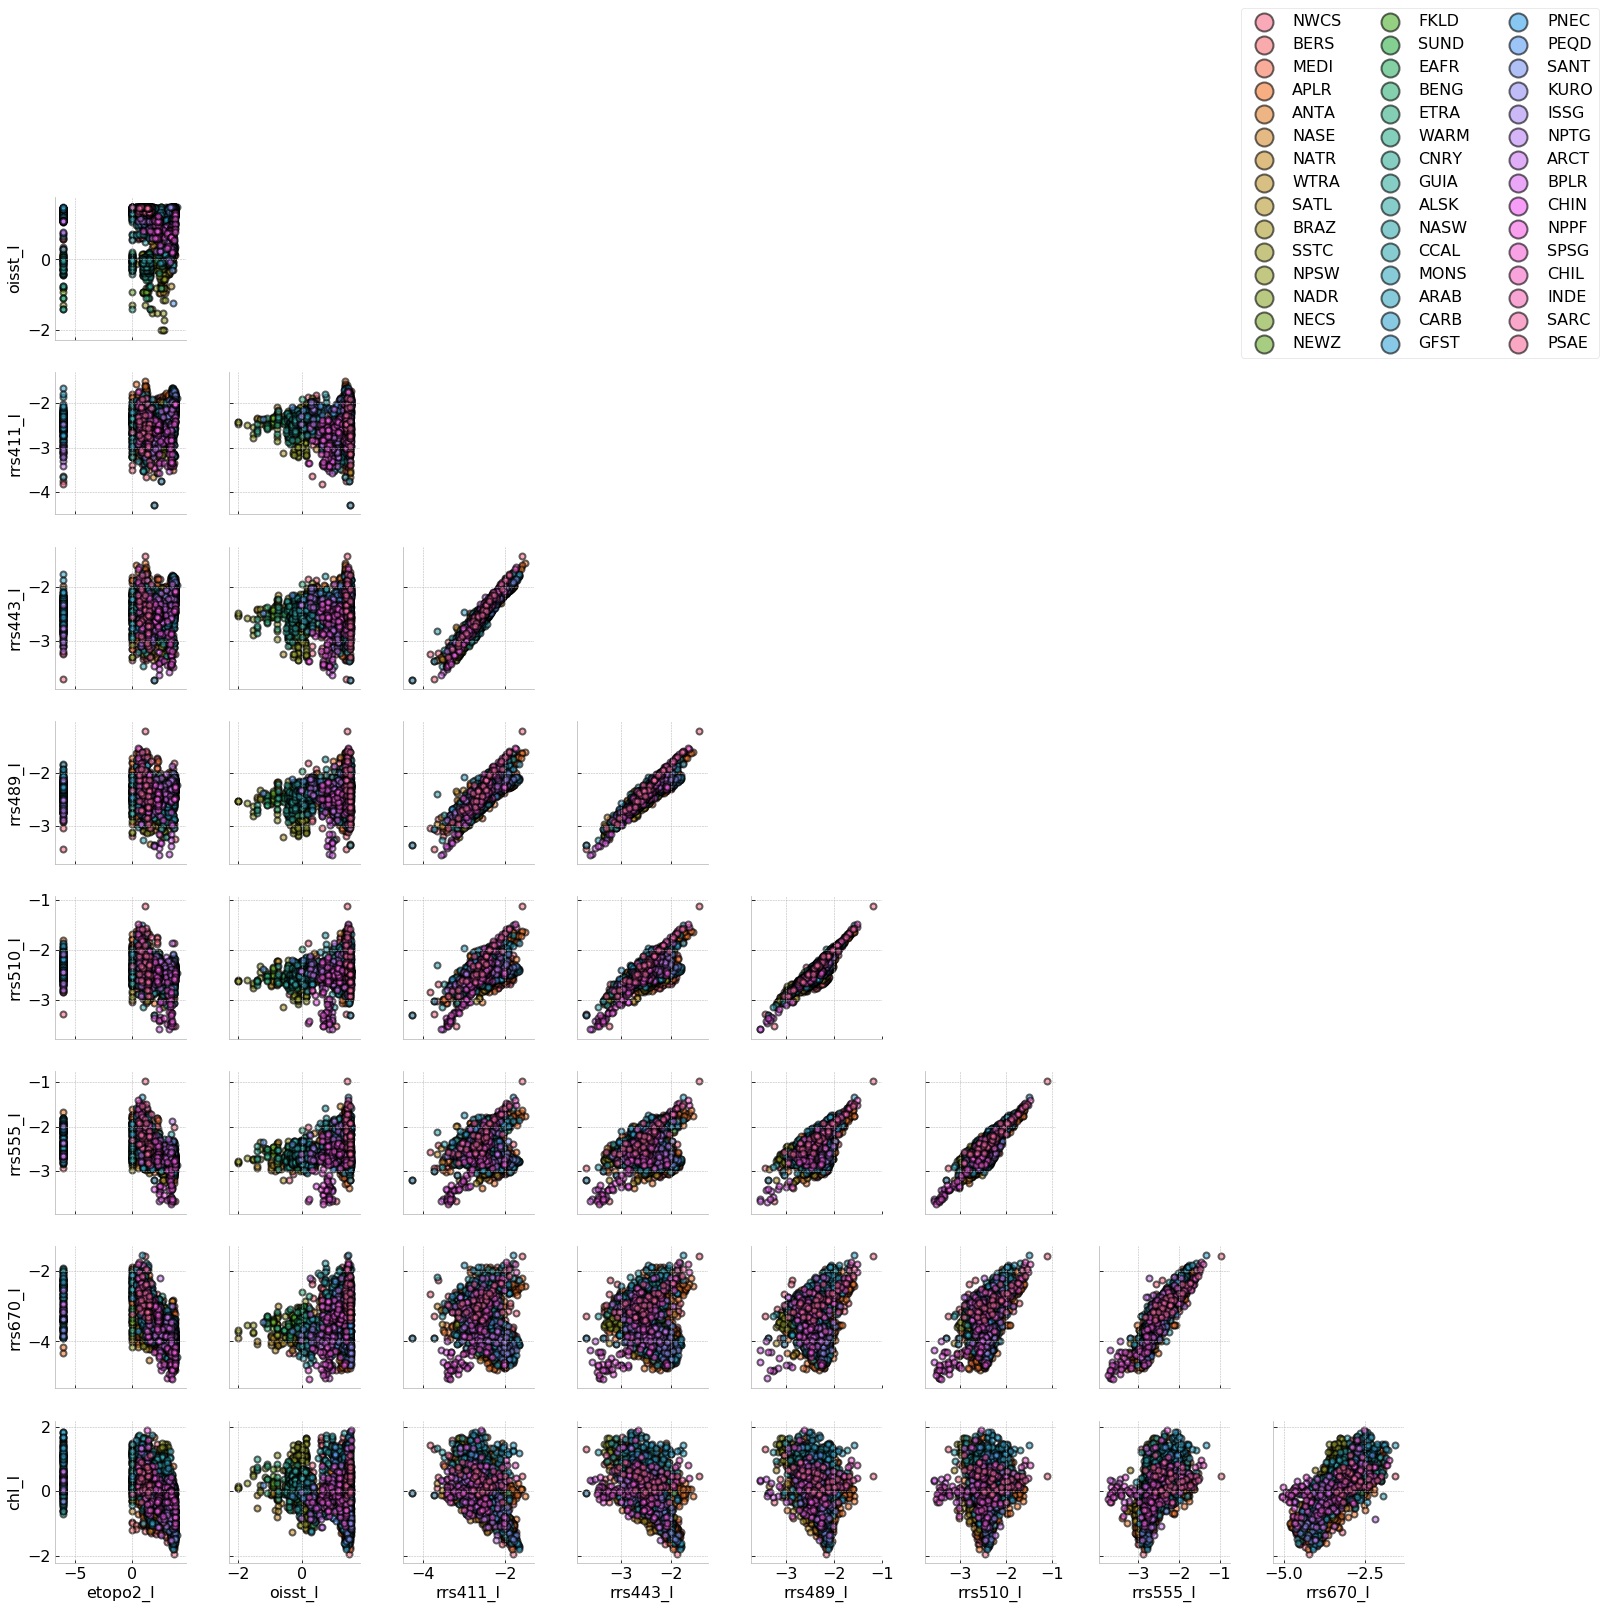

In [219]:
g = PairGrid(df_l, vars=['etopo2_l', 'oisst_l', 
                         'rrs411_l', 'rrs443_l', 'rrs489_l', 
                         'rrs510_l', 'rrs555_l', 'rrs670_l',
                         'chl_l'], hue='provCode', diag_sharey=False,
             )
glow = g.map_lower(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
#gh = g.map_diag(kdeplot, lw=3)
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
#for i, j in zip(*np.tril_indices_from(g.axes, 0)):
#    g.axes[i, j].set_facecolor('gray')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3,
            markerscale=3, fontsize=16);

There are some pretty vague relationships of the various potential predictors with chl.
Next, I add some ratios of the log transform rrs bands. The difference with the legacy algorithm is that here I'm looking at ratios of log-transformed data; OC4 is a log transformed ratio of data.

In [226]:
df_l.insert(df_l.shape[1]-1, 'r411_2_r555', df_l.rrs411_l / df_l.rrs555_l)

In [227]:
df_l.insert(df_l.shape[1]-1, 'mxbl2gr',
           df_l[['rrs443_l', 'rrs489_l', 'rrs510_l']].max(axis=1) / df_l.rrs555_l)

In [230]:
df_l.insert(df_l.shape[1]-1, 'mxblID', df_l[['rrs443_l', 'rrs489_l', 'rrs510_l']].idxmax(axis=1))

In [234]:
df_l.insert(df_l.shape[1]-1, 'r411_toRed', df_l.rrs411_l / df_l.rrs670_l)

In [241]:
df_l.to_pickle('./pickleJar/df_log.pkl')

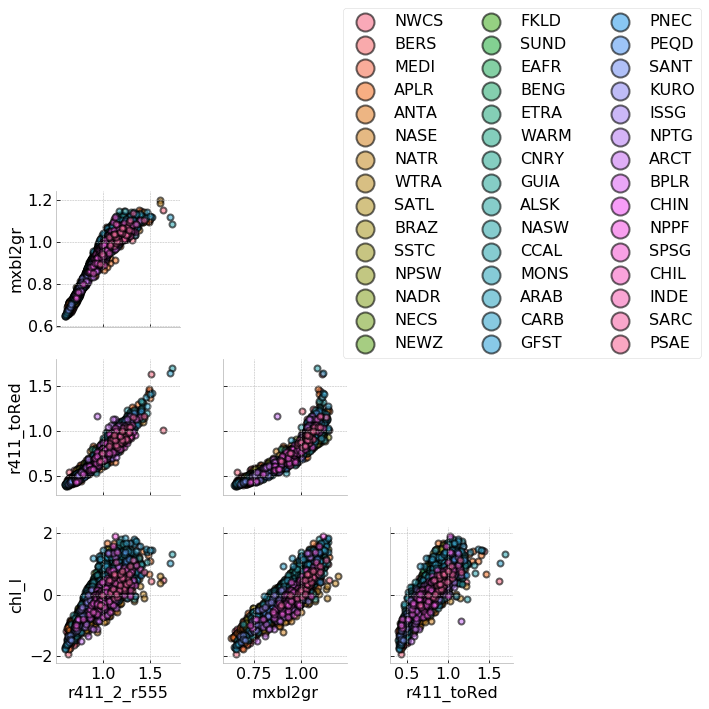

In [236]:
g = PairGrid(df_l, vars=['r411_2_r555', 'mxbl2gr', 'r411_toRed', 
                         'chl_l'], hue='provCode', diag_sharey=False,
             )
glow = g.map_lower(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
#gh = g.map_diag(kdeplot, lw=3)
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
#for i, j in zip(*np.tril_indices_from(g.axes, 0)):
#    g.axes[i, j].set_facecolor('gray')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3,
            markerscale=3, fontsize=16);

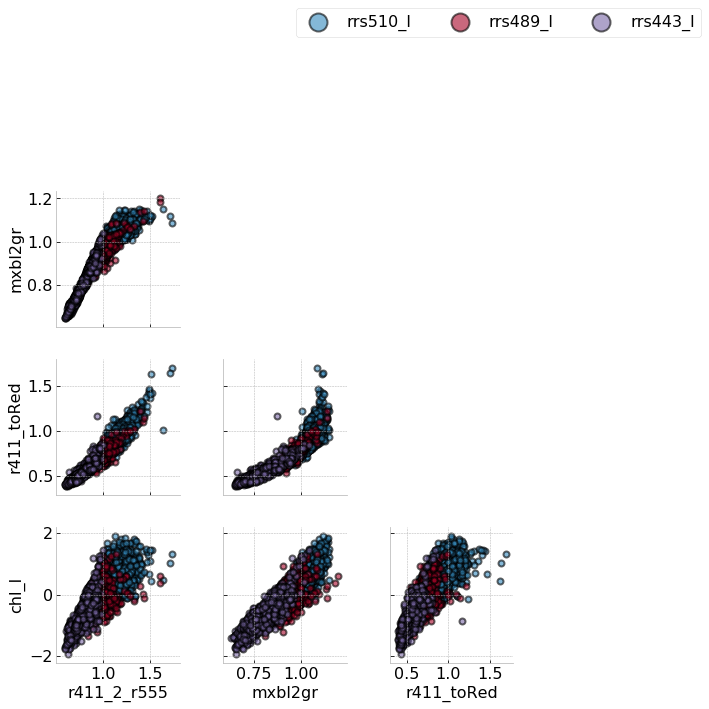

In [237]:
g = PairGrid(df_l, vars=['r411_2_r555', 'mxbl2gr', 'r411_toRed', 
                         'chl_l'], hue='mxblID', diag_sharey=False,
             )
glow = g.map_lower(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
#gh = g.map_diag(kdeplot, lw=3)
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
#for i, j in zip(*np.tril_indices_from(g.axes, 0)):
#    g.axes[i, j].set_facecolor('gray')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3,
            markerscale=3, fontsize=16);

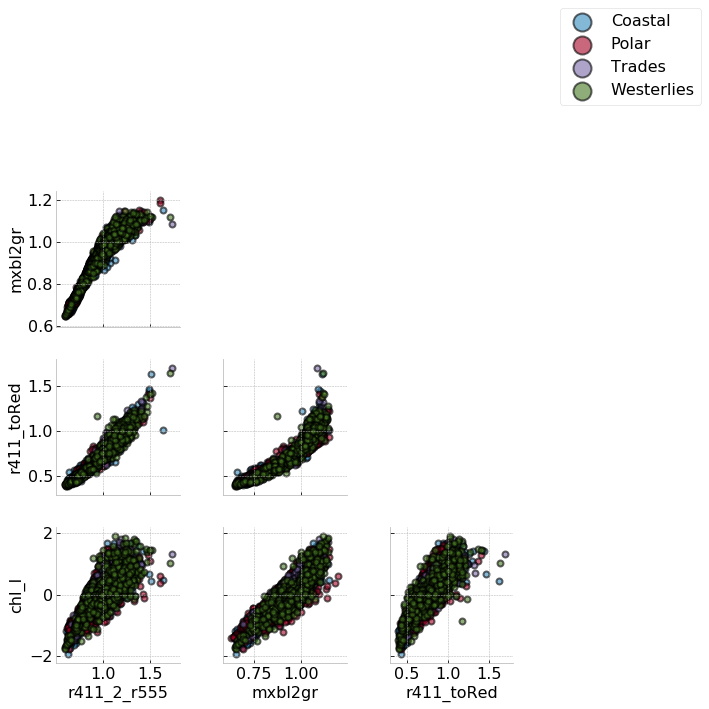

In [239]:
g = PairGrid(df_l, vars=['r411_2_r555', 'mxbl2gr', 'r411_toRed', 
                         'chl_l'], hue='biome', diag_sharey=False,
             )
glow = g.map_lower(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
#gh = g.map_diag(kdeplot, lw=3)
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
#for i, j in zip(*np.tril_indices_from(g.axes, 0)):
#    g.axes[i, j].set_facecolor('gray')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper right',
            markerscale=3, fontsize=16);

So now we have a few models to play with, we can start building a series of hierarchical models, each series made up of the two different datasets we created (legacy and log-transformed predictors and their ratios) and increasingly complex linear models.
I then go on to comparing the relative performance of these models.

###  Pooled High Order Polynomial Regression

I already fit three pooled $3^{rd}$ and $4^{th}$ order models in the [previous tutorial](). The figure below is a depiction of the structure of these models.
<img src="./kruschke_diagrams/oc34.png", width=650, height=600>

After fitting these I had pickled these models. Below I load them for the purpose of comparing them with the models developed here.

In [41]:
with open('./pickleJar/models.pkl', 'rb') as fmod:
    pooled_mdl_dict = pickle.load(fmod)

Next I prep the data for modeling. These steps will improve the model code readability.

In [77]:
# copy the input data in the dataframe to a numpy array
x_input = df_train.as_matrix(columns=['mxBl2Gr%s' %i for i in ['', '_2','_3','_4']])
# verify input array shape
x_input.shape

(1016, 4)

In [73]:
# check the right columns were grabbed
x_input[:3]

array([[-0.26786697,  0.07175271, -0.01922018,  0.00514845],
       [-0.22045677,  0.04860119, -0.01071446,  0.00236208],
       [-0.26853699,  0.07211211, -0.01936477,  0.00520016]])

### Hierarchical Modeling:

Quoting from Betancourt & Girolami (2013):
"Hierarchical models are defined by the organization of a model's parameters into exchangeable groups, and the resulting conditional independencies between those groups."

Thus the inference is conducted on multiple levels with cluster-specific parameters  having a common prior of  referred to as *hyper-priors*. This constitutes a link through which information between clusters can flow. 

Next are three model formulations; varying intercepts, varying effects, and varying effects with covarying slopes and intercepts.

#### Varying Intercepts

A varying intercepts model features a common slope shared between groups and a set of group-specific intercepts.

In [ ]:
n_clusters = df_train.max_blue_id_cat.unique().size # number of clusters
clust_idx = df_train.max_blue_id_cat.values # vector of cluster indices taken from the dataframe

In [60]:
with pm.Model() as m_vi:
    # hyper-priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=10)
    sig_alpha = pm.HalfCauchy('sig_alpha', 2)
    
    
    # priors
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=n_clusters) # decentering prior
    alpha = pm.Deterministic('alpha', mu_alpha + alpha_offset * sig_alpha)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 2)
    
    # deterministic form of the model
    mu_ = alpha[clust_idx] + beta * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.Normal('chlor_a', mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_vi = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha_offset, sig_alpha_log__, mu_alpha]
100%|██████████| 7000/7000 [01:25<00:00, 82.29it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.621494553028, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.720327425747, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth

**Results summary for varying intercepts**

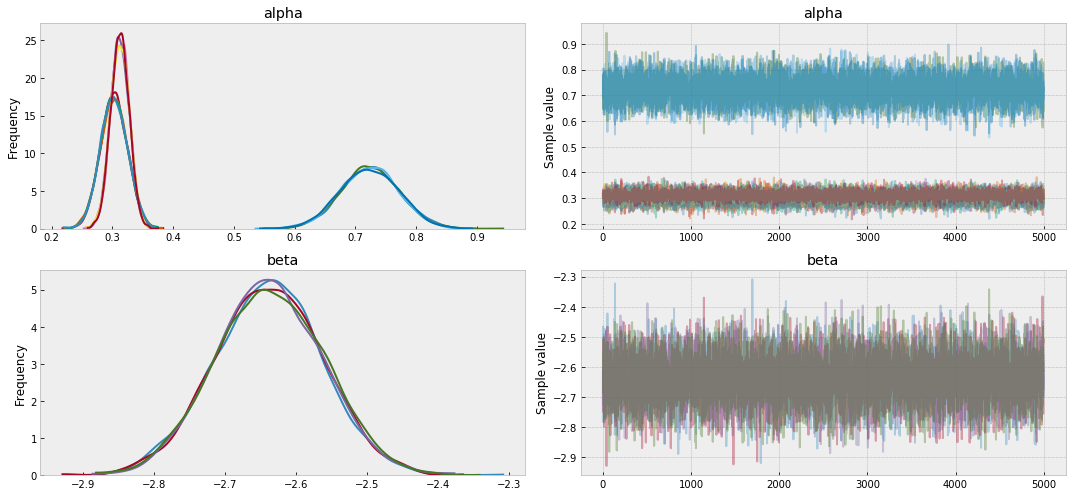

In [25]:
pm.traceplot(trace_m_vi, varnames=['alpha', 'beta'], figsize=(15, 7));

In [45]:
pm.summary(trace_m_vi, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.723810,0.047763,0.000482,0.628671,0.816183,9889.0,1.000125
alpha__1,0.302233,0.022174,0.000201,0.258898,0.345042,12930.0,0.999985
alpha__2,0.312041,0.015328,0.000120,0.282193,0.341904,13538.0,0.999977
beta,-2.639179,0.075709,0.000789,-2.788704,-2.492724,9521.0,1.000130


### Varying Effects:

The above show good convergence. The common slope is significantly negative, confirming a decrease in the $\frac{blue}{green}$ ratio with increasing chlorophyll. All three intercepts are significantly positive, and at least one cluster has a significantly different intercept. However, the single slope may make the model too inflexible. This can be addressed by incorporating cluster-specific slopes as well. The presence of both group-based slopes and group-based intercepts is referred to by the more general term of *varying effects*

The implementation of varying effects is shown below:

In [67]:
with pm.Model() as m_ve:
    #hyper-priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=10)
    sig_alpha = pm.HalfCauchy('sig_alpha', 2)
    mu_beta = pm.Normal('mu_beta', mu=0, sd=10)
    sig_beta = pm.HalfCauchy('sig_beta', 2)
    
    # priors
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=n_clusters)
    beta_offset = pm.Normal('beta_offset', mu=0, sd=1, shape=n_clusters)
    alpha_nc = pm.Deterministic('alpha_nc', mu_alpha + alpha_offset * sig_alpha)
    beta_nc = pm.Deterministic('beta_nc', mu_beta + beta_offset * sig_beta)
    sigma = pm.HalfCauchy('sigma', 2)
    nu_ = pm.HalfCauchy('nu', 5)
    # deterministic form of the model
    mu_ = alpha_nc[clust_idx] + beta_nc[clust_idx] * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.StudentT('chlor_a', nu=nu_, mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_ve = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_log__, sigma_log__, beta_offset, alpha_offset, sig_beta_log__, mu_beta, sig_alpha_log__, mu_alpha]
100%|██████████| 6000/6000 [04:40<00:00, 21.41it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666270709659, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `ta

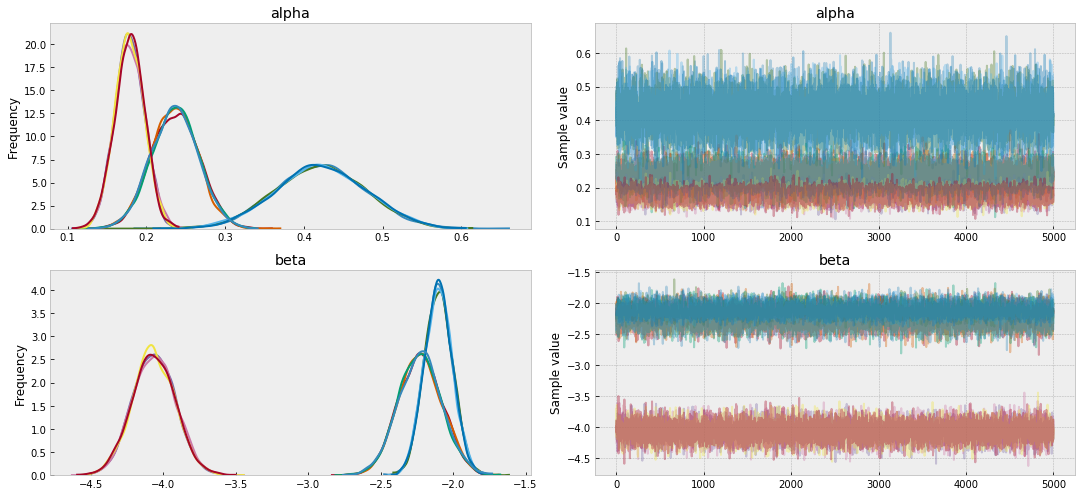

In [34]:
pm.traceplot(trace_m_ve, varnames=['alpha', 'beta'], figsize=(15, 7));

In [47]:
pm.summary(trace_m_ve, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.421201,0.057557,0.000469,0.306911,0.531422,13793.0,0.999959
alpha__1,0.235754,0.029852,0.000257,0.175900,0.292583,14149.0,0.999948
alpha__2,0.178563,0.018836,0.000140,0.142702,0.216388,15454.0,0.999932
beta__0,-2.101171,0.096530,0.000767,-2.283403,-1.908664,13956.0,0.999971
beta__1,-2.228004,0.149608,0.001342,-2.525108,-1.939888,14075.0,0.999987
beta__2,-4.067230,0.146652,0.001143,-4.360344,-3.788972,15118.0,0.999923


In [52]:
m_oc4 = pooled_mdl_dict['models']['oc4']
m_oc4_3 = pooled_mdl_dict['models']['oc4_3']
trace_oc4 = pooled_mdl_dict['traces']['oc4']
trace_oc4_3 = pooled_mdl_dict['traces']['oc4_3']

In [55]:
traces_so_far = [trace_oc4, trace_oc4_3, trace_m_vi, trace_m_ve]
models_so_far = [m_oc4, m_oc4_3, m_vi, m_ve]
model_names = ['pooled_poly_4', 'pooled_poly_3', 'var_intcepts', 'var_eff']
df_comp = pm.compare(traces=traces_so_far, models=models_so_far)
df_comp.index = [model_names[i] for i in df_comp.index]
df_comp.iloc[:,:-1]

,WAIC,pWAIC,dWAIC,weight,SE,dSE
pooled_poly_4,379.52,5.56,0,0,56.46,0
pooled_poly_3,380.38,4.76,0.86,0.85,56.6,3.19
var_eff,387.29,8.96,7.77,0,52.34,15.79
var_intcepts,513.07,5.3,133.55,0.15,45.58,34.28


<u>Refs:</u>

[1.](https://arxiv.org/abs/1312.0906) Betancourt, M. & Girolami, M. 2013. Hamiltonian Monte Carlo for Hierarchical Models. [arXiv:1312.0906](https://arxiv.org/abs/1312.0906)